In [32]:
# Needed for importing target encoder, restart after running
!pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 41.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from datetime import datetime
from google.colab import userdata
import os
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors
from sklearn.preprocessing import TargetEncoder

pd.set_option("display.max_colwidth", None)

In [58]:
# Load data from github
!wget https://raw.githubusercontent.com/julietlawton/youtube-views-prediction/main/youtube-dataset/US_category_id.json
!wget https://raw.githubusercontent.com/julietlawton/youtube-views-prediction/main/youtube-dataset/USvideos.csv

--2024-06-10 05:52:35--  https://raw.githubusercontent.com/julietlawton/youtube-views-prediction/main/youtube-dataset/US_category_id.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8496 (8.3K) [text/plain]
Saving to: ‘US_category_id.json.3’

US_category_id.json 100%[===================>]   8.30K  --.-KB/s    in 0s      

2024-06-10 05:52:35 (77.4 MB/s) - ‘US_category_id.json.3’ saved [8496/8496]

--2024-06-10 05:52:35--  https://raw.githubusercontent.com/julietlawton/youtube-views-prediction/main/youtube-dataset/USvideos.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP re

In [59]:
# Read data into dataframe
youtube_df = pd.read_csv('USvideos.csv')
youtube_df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/shantellmartin\nCANDICE - https://www.lovebilly.com\n\nfilmed this video in 4k on this -- http://amzn.to/2sTDnRZ\nwith this lens -- http://amzn.to/2rUJOmD\nbig drone - http://tinyurl.com/h4ft3oy\nOTHER GEAR --- http://amzn.to/2o3GLX5\nSony CAMERA http://amzn.to/2nOBmnv\nOLD CAMERA; http://amzn.to/2o2cQBT\nMAIN LENS; http://amzn.to/2od5gBJ\nBIG SONY CAMERA; http://amzn.to/2nrdJRO\nBIG Canon CAMERA; http://tinyurl.com/jn4q4vz\nBENDY TRIPOD THING; http://tinyurl.com/gw3ylz2\nYOU NEED THIS FOR THE BENDY TRIPOD; http://tinyurl.com/j8mzzua\nWIDE LENS; http://tinyurl.com/jkfcm8t\nMORE EXPENSIVE WIDE LENS; http://tinyurl.com/zrdgtou\nSMALL CAMERA; http://tinyurl.com/hrrzhor\nMICROPHONE; http://tinyurl.com/zefm4jy\nOTHER MICROPHONE; http://tinyurl.com/jxgpj86\nOLD DRONE (cheaper but still great);http://tinyurl.com/zcfmnmd\n\nfollow me; on http://instagram.com/caseyneistat\non https://www.facebook.com/cneistat\non https://twitter.com/CaseyNeistat\n\namazing intro song by https://soundcloud.com/discoteeth\n\nad disclosure. THIS IS NOT AN AD. not selling or promoting anything. but samsung did produce the Shantell Video as a 'GALAXY PROJECT' which is an initiative that enables creators like Shantell and me to make projects we might otherwise not have the opportunity to make. hope that's clear. if not ask in the comments and i'll answer any specifics.
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with John Oliver (HBO),LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week tonight donald trump""|""john oliver trump""|""donald trump""",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John Oliver discusses what we've learned so far and enlists our catheter cowboy to teach Donald Trump what he hasn't.\n\nConnect with Last Week Tonight online...\n\nSubscribe to the Last Week Tonight YouTube channel for more almost news as it almost happens: www.youtube.com/user/LastWeekTonight\n\nFind Last Week Tonight on Facebook like your mom would: http://Facebook.com/LastWeekTonight\n\nFollow us on Twitter for news about jokes and jokes about news: http://Twitter.com/LastWeekTonight\n\nVisit our official site for all that other stuff at once: http://www.hbo.com/lastweektonight"
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Lele Pons",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""|""racist""|""superman""|""love""|""rudy mancuso poo bear black white official music video""|""iphone x by pineapple""|""lelepons""|""hannahstocking""|""rudymancuso""|""inanna""|""anwar""|""sarkis""|""shots""|""shotsstudios""|""alesso""|""anitta""|""brazil""|""Getting My Driver's License | Lele Pons""",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► https://www.youtube.com/channel/UC5jkXpfnBhlDjqh0ir5FsIQ?sub_confirmation=1\n\nTHANKS FOR WATCHING! LIKE & SUBSCRIBE FOR MORE VIDEOS!\n-----------------------------------------------------------\nFIND ME ON: \nInstagram | http://instagram.com/rudymancuso\nTwitter | http://twitter.com/rudymancuso\nFacebook | http://facebook.com/rudymancuso\n\nCAST: \nRudy Mancuso | http://youtube.com/c/rudymancuso\nLele Pons | http://youtube.com/c/lelepons\nKing Bach | https://youtube.com/user/BachelorsPadTv\n\nVideo Effects: \nCaleb Natale | https://instagram.com/calebnatale\n\nPA:\nPaulina Gregory\n\n\nShots Studios Channels:\nAle

In [44]:
youtube_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40949 non-null  object
 1   trending_date           40949 non-null  object
 2   title                   40949 non-null  object
 3   channel_title           40949 non-null  object
 4   category_id             40949 non-null  int64 
 5   publish_time            40949 non-null  object
 6   tags                    40949 non-null  object
 7   views                   40949 non-null  int64 
 8   likes                   40949 non-null  int64 
 9   dislikes                40949 non-null  int64 
 10  comment_count           40949 non-null  int64 
 11  thumbnail_link          40949 non-null  object
 12  comments_disabled       40949 non-null  bool  
 13  ratings_disabled        40949 non-null  bool  
 14  video_error_or_removed  40949 non-null  bool  
 15  de

In [60]:
# Extract video category labels and ids from auxillary JSON file
with open("US_category_id.json", "r") as f:
    data = json.load(f)

# Create a dictionary mapping ids to lablels
categories = {}
for item in data['items']:
    id = int(item['id'])
    category = item['snippet']['title']
    categories[id] = category

print(categories)

{1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music', 15: 'Pets & Animals', 17: 'Sports', 18: 'Short Movies', 19: 'Travel & Events', 20: 'Gaming', 21: 'Videoblogging', 22: 'People & Blogs', 23: 'Comedy', 24: 'Entertainment', 25: 'News & Politics', 26: 'Howto & Style', 27: 'Education', 28: 'Science & Technology', 29: 'Nonprofits & Activism', 30: 'Movies', 31: 'Anime/Animation', 32: 'Action/Adventure', 33: 'Classics', 34: 'Comedy', 35: 'Documentary', 36: 'Drama', 37: 'Family', 38: 'Foreign', 39: 'Horror', 40: 'Sci-Fi/Fantasy', 41: 'Thriller', 42: 'Shorts', 43: 'Shows', 44: 'Trailers'}


In [61]:
# Add category labels for each video
youtube_df['category_label'] = youtube_df['category_id'].apply(lambda x: categories[x])
youtube_df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_label
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/shantellmartin\nCANDICE - https://www.lovebilly.com\n\nfilmed this video in 4k on this -- http://amzn.to/2sTDnRZ\nwith this lens -- http://amzn.to/2rUJOmD\nbig drone - http://tinyurl.com/h4ft3oy\nOTHER GEAR --- http://amzn.to/2o3GLX5\nSony CAMERA http://amzn.to/2nOBmnv\nOLD CAMERA; http://amzn.to/2o2cQBT\nMAIN LENS; http://amzn.to/2od5gBJ\nBIG SONY CAMERA; http://amzn.to/2nrdJRO\nBIG Canon CAMERA; http://tinyurl.com/jn4q4vz\nBENDY TRIPOD THING; http://tinyurl.com/gw3ylz2\nYOU NEED THIS FOR THE BENDY TRIPOD; http://tinyurl.com/j8mzzua\nWIDE LENS; http://tinyurl.com/jkfcm8t\nMORE EXPENSIVE WIDE LENS; http://tinyurl.com/zrdgtou\nSMALL CAMERA; http://tinyurl.com/hrrzhor\nMICROPHONE; http://tinyurl.com/zefm4jy\nOTHER MICROPHONE; http://tinyurl.com/jxgpj86\nOLD DRONE (cheaper but still great);http://tinyurl.com/zcfmnmd\n\nfollow me; on http://instagram.com/caseyneistat\non https://www.facebook.com/cneistat\non https://twitter.com/CaseyNeistat\n\namazing intro song by https://soundcloud.com/discoteeth\n\nad disclosure. THIS IS NOT AN AD. not selling or promoting anything. but samsung did produce the Shantell Video as a 'GALAXY PROJECT' which is an initiative that enables creators like Shantell and me to make projects we might otherwise not have the opportunity to make. hope that's clear. if not ask in the comments and i'll answer any specifics.,People & Blogs
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with John Oliver (HBO),LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week tonight donald trump""|""john oliver trump""|""donald trump""",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John Oliver discusses what we've learned so far and enlists our catheter cowboy to teach Donald Trump what he hasn't.\n\nConnect with Last Week Tonight online...\n\nSubscribe to the Last Week Tonight YouTube channel for more almost news as it almost happens: www.youtube.com/user/LastWeekTonight\n\nFind Last Week Tonight on Facebook like your mom would: http://Facebook.com/LastWeekTonight\n\nFollow us on Twitter for news about jokes and jokes about news: http://Twitter.com/LastWeekTonight\n\nVisit our official site for all that other stuff at once: http://www.hbo.com/lastweektonight",Entertainment
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Lele Pons",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""|""racist""|""superman""|""love""|""rudy mancuso poo bear black white official music video""|""iphone x by pineapple""|""lelepons""|""hannahstocking""|""rudymancuso""|""inanna""|""anwar""|""sarkis""|""shots""|""shotsstudios""|""alesso""|""anitta""|""brazil""|""Getting My Driver's License | Lele Pons""",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► https://www.youtube.com/channel/UC5jkXpfnBhlDjqh0ir5FsIQ?sub_confirmation=1\n\nTHANKS FOR WATCHING! LIKE & SUBSCRIBE FOR MORE VIDEOS!\n-----------------------------------------------------------\nFIND ME ON: \nInstagram | http://instagram.com/rudymancuso\nTwitter | http://twitter.com/rudymancuso\nFacebook | http://facebook.com/rudymancuso\n\nCAST: \nRudy Mancuso | http://youtube.com/c/rudymancuso\nLele Pons | http://youtube.com/c/lelepons\nKing Bach | https://youtube.com/user/BachelorsPadTv\n\nVideo Effects: \nCaleb Natale | https://instagram.com/calebnatale\n\nPA:\nPauli

In [64]:
# View how many videos are in each category
youtube_df['category_label'].value_counts()

category_label
Entertainment            9964
Music                    6472
Howto & Style            4146
Comedy                   3457
People & Blogs           3210
News & Politics          2487
Science & Technology     2401
Film & Animation         2345
Sports                   2174
Education                1656
Pets & Animals            920
Gaming                    817
Travel & Events           402
Autos & Vehicles          384
Nonprofits & Activism      57
Shows                      57
Name: count, dtype: int64

In [65]:
# View trending date range
print(f"{youtube_df['trending_date'].min()} - {youtube_df['trending_date'].max()}")

17.01.12 - 18.31.05


In [66]:
# Convert timestamps to UTC
youtube_df['publish_time'] = youtube_df['publish_time'].apply(lambda row: datetime.fromisoformat(row.replace("Z", "+00:00")))

In [67]:
# Reorder the data so that all the duplicate videos appear together, ordered by views
youtube_df.sort_values(['views', 'video_id'], inplace=True)

# Remove all duplicate videos, keeping the last instance of each
youtube_df.drop_duplicates(subset=['video_id'], keep='last', inplace=True)
youtube_df.reset_index(drop=True, inplace=True)
youtube_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6351 entries, 0 to 6350
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   video_id                6351 non-null   object             
 1   trending_date           6351 non-null   object             
 2   title                   6351 non-null   object             
 3   channel_title           6351 non-null   object             
 4   category_id             6351 non-null   int64              
 5   publish_time            6351 non-null   datetime64[ns, UTC]
 6   tags                    6351 non-null   object             
 7   views                   6351 non-null   int64              
 8   likes                   6351 non-null   int64              
 9   dislikes                6351 non-null   int64              
 10  comment_count           6351 non-null   int64              
 11  thumbnail_link          6351 non-null   obj

In [115]:
# Since channel title is not useful by itself, we will use YouTube's API to get
# the subscriber count for each channel as a measure of channel popularity, which
# is a generalizable concept. We will also use video count as a measure of
# creator activity

# Set up credentials
# NOTE: Disable OAuthlib's HTTPS verification when running locally.
# *DO NOT* leave this option enabled in production.
os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

api_service_name = "youtube"
api_version = "v3"
developer_key = userdata.get('YOUTUBE-API-KEY')
scopes = ["https://www.googleapis.com/auth/youtube.readonly"]

youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey=developer_key)


# Create an object to store the statistics for each channel
channel_statistics = {}

# Get list of unique channel names
channel_names = list(youtube_df['channel_title'].unique())

for channel in channel_names:
  # Send request for each channel
  request = youtube.channels().list(
      part="statistics",
      forUsername=channel
  )

  # Extract values from the JSON response and add to the statistics dictionary
  response = request.execute()

  if response['pageInfo']['totalResults'] > 0:
    subscriber_count = response['items'][0]['statistics']['subscriberCount']
    video_count = response['items'][0]['statistics']['videoCount']
    channel_statistics[channel] = {'subscriber_count': subscriber_count, 'video_count': video_count}
  else:
    channel_statistics[channel] = {'subscriber_count': np.nan, 'video_count': np.nan}


In [116]:
with open("channel_statistics.json", "w") as outfile:
    json.dump(channel_statistics, outfile)

In [117]:
print(channel_statistics)

{'Newsy': {'subscriber_count': nan, 'video_count': nan}, 'GoDucksdotcom': {'subscriber_count': '63700', 'video_count': '7457'}, 'Palo Alto Online': {'subscriber_count': nan, 'video_count': nan}, 'Associated Press': {'subscriber_count': nan, 'video_count': nan}, '90s Commercials': {'subscriber_count': nan, 'video_count': nan}, 'OjO Commuter Scooter by OjO Electric': {'subscriber_count': nan, 'video_count': nan}, 'University of Rochester EEOC Complainants': {'subscriber_count': nan, 'video_count': nan}, 'Single Shot': {'subscriber_count': nan, 'video_count': nan}, 'Adam Whitley': {'subscriber_count': nan, 'video_count': nan}, 'Business Insider UK': {'subscriber_count': nan, 'video_count': nan}, 'Vostok.bike': {'subscriber_count': nan, 'video_count': nan}, 'J Gasser': {'subscriber_count': nan, 'video_count': nan}, 'Fox News': {'subscriber_count': nan, 'video_count': nan}, 'Cleveland Browns': {'subscriber_count': nan, 'video_count': nan}, 'taalk com': {'subscriber_count': nan, 'video_count

In [118]:
df = pd.DataFrame.from_dict(channel_statistics, orient='index')

In [121]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2199 entries, Newsy to ChildishGambinoVEVO
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   subscriber_count  629 non-null    object
 1   video_count       629 non-null    object
dtypes: object(2)
memory usage: 51.5+ KB


In [70]:
# Extract hour, time of day, and day of week
# Morning 5 am to 12 pm (noon)
# Afternoon 12 pm to 5 pm
# Evening 5 pm to 9 pm
# Night 9 pm to 4 am
def get_time_day(row):
  day = row.weekday()
  hour = row.hour
  period = 0 if hour >= 5 and hour < 12 else \
   (1 if hour >= 12 and hour < 17 else (2 if hour >= 17 and hour < 21 else 3))
  return pd.Series([hour, period, day], index=['hour', 'time_of_day', 'day_of_week'])

youtube_df[['hour', 'time_of_day', 'day_of_week']] = youtube_df['publish_time'].apply(get_time_day)
youtube_df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_label,hour,time_of_day,day_of_week
0,y6KYFcta4SE,18.28.01,"1 dead, others injured after Ky. school shooting",Newsy,25,2018-01-23 15:30:01+00:00,"shooting|""kentucky""|""breaking news""|""u.s. news""|""marshall county high school""|""dead""|""fatality""|""injured""|""students""|""school""|""governor matt bevin""",559,9,0,4,https://i.ytimg.com/vi/y6KYFcta4SE/default.jpg,False,False,False,Kentucky Gov. Matt Bevin confirmed there was a shooting at a high school in western Kentucky.\n\nLearn more about this story at www.newsy.com/75628/\n\nFind more videos like this at www.newsy.com\n\nFollow Newsy on Facebook: www.facebook.com/newsyvideos\nFollow Newsy on Twitter: www.twitter.com/newsyvideos,News & Politics,15,1,1
1,-JVITToppE0,17.17.11,Coach Taggart Monday Presser Ahead of Arizona,GoDucksdotcom,17,2017-11-13 20:41:45+00:00,"Oregon|""Ducks""|""college athletics""|""college football""|""college basketball""|""Tracktown USA""|""Track & Field""|""Hayward Field""|""Autzen Stadium""|""NIKE""",704,10,2,5,https://i.ytimg.com/vi/-JVITToppE0/default.jpg,False,False,False,Coach Taggart addresses the media ahead of the Duck's match up this weekend against the Arizona Wildcats. #GoDucks #DoSomething,Sports,20,2,0
2,dQMZLXaa1L8,18.29.01,Artwork Forge,Palo Alto Online,17,2018-01-10 23:53:56+00:00,[none],745,1,0,0,https://i.ytimg.com/vi/dQMZLXaa1L8/default.jpg,False,False,False,"Artwork Forge II - an art installation created by artist Toby Atticus Fraley, is currently on display in front of Palo Alto City Hall through April 2018. \n\nBy inserting four quarters into the machine, anyone can receive a custom-made piece of artwork sourced from what is currently trending on social media in the local vicinity. \n\nTake a peek into what this little art machine can do.",Sports,23,3,2
3,zeQaJGkFyqQ,18.18.01,"Raw: 3 South Carolina Deputies, 1 Officer Shot",Associated Press,25,2018-01-16 12:16:44+00:00,"news|""associated press""|""ap""|""ap online""|""associated press style""|""breaking news""|""latest news""|""business""|""finance""|""politics""|""local news""|""commentary""|""reports""|""current affairs""|""top news""|""headlines""|""news today""|""charlotte""|""north carolina""|""united states""|""north america""|""south carolina""|""national""|""regional (ap video-us only""|""charlotte police shooting""|""raw""|""south""|""carolina""|""deputies""|""officer""|""shot""",748,9,0,0,https://i.ytimg.com/vi/zeQaJGkFyqQ/default.jpg,True,False,False,"Three deputies and one police officer were shot and wounded in northern South Carolina early Tuesday. State police say a suspect was also wounded. The wounded officers were taken to a hospital in Charlotte, North Carolina. (Jan. 16)\n\nSubscribe for more Breaking News: http://smarturl.it/AssociatedPress\r\nGet updates and more Breaking News here: http://smarturl.it/APBreakingNews\r\n\r\nThe Associated Press is the essential global news network, delivering fast, unbiased news from every corner of the world to all media platforms and formats.\r\nAP’s commitment to independent, comprehensive journalism has deep roots. Founded in 1846, AP has covered all the major news events of the past 165 years, providing high-quality, informed reporting of everything from wars and elections to championship games and royal weddings. AP is the largest and most trusted source of independent news and information.\r\nToday, AP employs the latest technology to collect and distribute content - we have daily uploads covering the latest and breaking news in the world of politics, sport and entertainment. Join us in a conversation about world events, the newsgathering process or whatever aspect of the news universe you find interesting or important. Subscribe: http://smarturl.it/AssociatedPress\r\n\r\nhttp://www.ap.org/\r\nhttps://plus.google

In [71]:
youtube_df.describe(include='all')

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_label,hour,time_of_day,day_of_week
count,6351,6351,6351,6351,6351.000000,6351,6351,6.351000e+03,6.351000e+03,6.351000e+03,6.351000e+03,6351,6351,6351,6351,6253,6351,6351.000000,6351.000000,6351.000000
unique,6351,205,6343,2199,NaN,NaN,5855,NaN,NaN,NaN,NaN,6351,2,2,2,6202,16,NaN,NaN,NaN
top,y6KYFcta4SE,18.14.06,Mission: Impossible - Fallout (2018) - Official Trailer - Paramount Pictures,ESPN,NaN,NaN,[none],NaN,NaN,NaN,NaN,https://i.ytimg.com/vi/y6KYFcta4SE/default.jpg,False,False,False,Jukin Media Verified (Original) * For licensing / permission to use: Contact - licensing(at)jukinmediadotcom\nSubmit your videos here: http://bit.ly/2iFnUya,Entertainment,NaN,NaN,NaN
freq,1,199,2,84,NaN,NaN,258,NaN,NaN,NaN,NaN,1,6246,6321,6348,11,1621,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,20.431271,2018-01-12 09:34:30.700204800+00:00,NaN,1.963852e+06,5.563130e+04,3.067872e+03,6.453191e+03,NaN,NaN,NaN,NaN,NaN,NaN,13.517871,1.661313,2.629350
min,NaN,NaN,NaN,NaN,1.000000,2006-07-23 08:24:11+00:00,NaN,5.590000e+02,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,17.000000,2017-12-13 04:38:24+00:00,NaN,1.591565e+05,2.772500e+03,1.270000e+02,3.720000e+02,NaN,NaN,NaN,NaN,NaN,NaN,9.000000,1.000000,1.000000
50%,NaN,NaN,NaN,NaN,24.000000,2018-01-25 02:00:01+00:00,NaN,5.181070e+05,1.190600e+04,4.440000e+02,1.266000e+03,NaN,NaN,NaN,NaN,NaN,NaN,15.000000,2.000000,3.000000
75%,NaN,NaN,NaN,NaN,25.000000,2018-03-13 09:32:25+00:00,NaN,1.474750e+06,3.842850e+04,1.507000e+03,4.070000e+03,NaN,NaN,NaN,NaN,NaN,NaN,18.000000,3.000000,4.000000
max,NaN,NaN,NaN,NaN,43.000000,2018-06-14 01:31:53+00:00,NaN,2.252119e+08,5.613827e+06,1.674420e+06,1.361580e+06,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,3.000000,6.000000


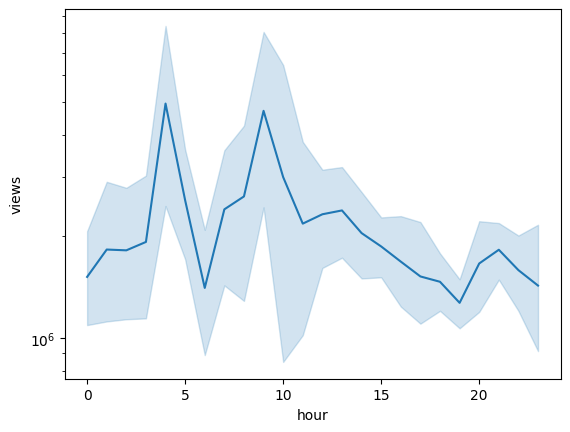

In [72]:
ax = sns.lineplot(data=youtube_df, x='hour', y='views')
ax.set_yscale('log')


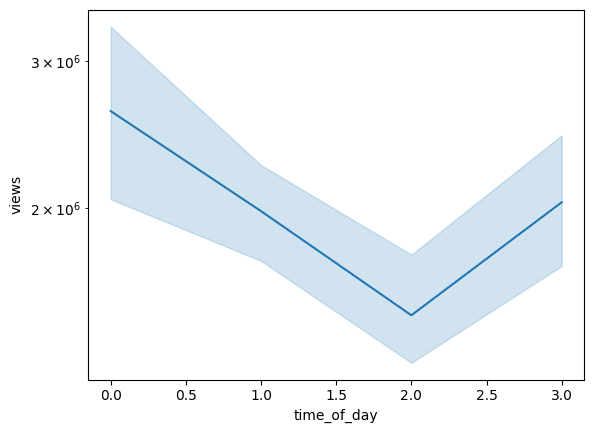

In [73]:
ax = sns.lineplot(data=youtube_df, x='time_of_day', y='views')
ax.set_yscale('log')

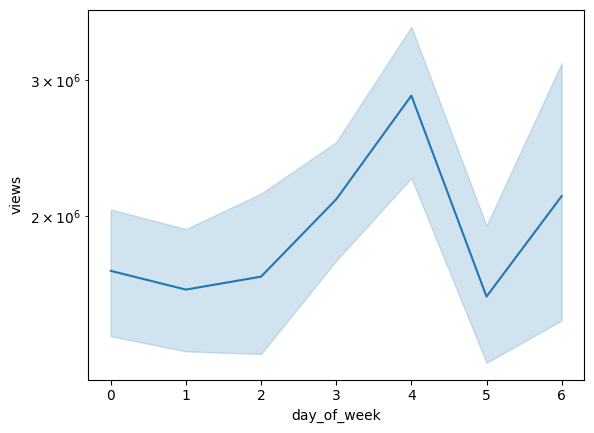

In [74]:
ax = sns.lineplot(data=youtube_df, x='day_of_week', y='views')
ax.set_yscale('log')

In [75]:
# Encode time variables using angular distance
# Each pair of features represent (x, y) coordinates and must be kept together
# cosine maps to x and sine maps to y
youtube_df['hour_x_coord'] = np.cos(youtube_df['hour'] * (2 * np.pi / 24))
youtube_df['hour_y_coord'] = np.sin(youtube_df['hour'] * (2 * np.pi / 24))

youtube_df['time_of_day_x_coord'] = np.cos(youtube_df['time_of_day'] * (2 * np.pi / 4))
youtube_df['time_of_day_y_coord'] = np.sin(youtube_df['time_of_day'] * (2 * np.pi / 4))

youtube_df['day_of_week_x_coord'] = np.cos(youtube_df['day_of_week'] * (2 * np.pi / 7))
youtube_df['day_of_week_y_coord'] = np.sin(youtube_df['day_of_week'] * (2 * np.pi / 7))

youtube_df.head()


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,category_label,hour,time_of_day,day_of_week,hour_x_coord,hour_y_coord,time_of_day_x_coord,time_of_day_y_coord,day_of_week_x_coord,day_of_week_y_coord
0,y6KYFcta4SE,18.28.01,"1 dead, others injured after Ky. school shooting",Newsy,25,2018-01-23 15:30:01+00:00,"shooting|""kentucky""|""breaking news""|""u.s. news""|""marshall county high school""|""dead""|""fatality""|""injured""|""students""|""school""|""governor matt bevin""",559,9,0,...,News & Politics,15,1,1,-0.707107,-7.071068e-01,6.123234e-17,1.000000e+00,0.623490,0.781831
1,-JVITToppE0,17.17.11,Coach Taggart Monday Presser Ahead of Arizona,GoDucksdotcom,17,2017-11-13 20:41:45+00:00,"Oregon|""Ducks""|""college athletics""|""college football""|""college basketball""|""Tracktown USA""|""Track & Field""|""Hayward Field""|""Autzen Stadium""|""NIKE""",704,10,2,...,Sports,20,2,0,0.500000,-8.660254e-01,-1.000000e+00,1.224647e-16,1.000000,0.000000
2,dQMZLXaa1L8,18.29.01,Artwork Forge,Palo Alto Online,17,2018-01-10 23:53:56+00:00,[none],745,1,0,...,Sports,23,3,2,0.965926,-2.588190e-01,-1.836970e-16,-1.000000e+00,-0.222521,0.974928
3,zeQaJGkFyqQ,18.18.01,"Raw: 3 South Carolina Deputies, 1 Officer Shot",Associated Press,25,2018-01-16 12:16:44+00:00,"news|""associated press""|""ap""|""ap online""|""associated press style""|""breaking news""|""latest news""|""business""|""finance""|""politics""|""local news""|""commentary""|""reports""|""current affairs""|""top news""|""headlines""|""news today""|""charlotte""|""north carolina""|""united states""|""north america""|""south carolina""|""national""|""regional (ap video-us only""|""charlotte police shooting""|""raw""|""south""|""carolina""|""deputies""|""officer""|""shot""",748,9,0,...,News & Politics,12,1,1,-1.000000,1.224647e-16,6.123234e-17,1.000000e+00,0.623490,0.781831
4,qg0GdM60syI,17.14.11,Huffy Metaloid Bicycle Commercial 1997,90s Commercials,27,2017-03-31 21:46:53+00:00,"90s commercials|""Huffy""",773,2,0,...,Education,21,3,4,0.707107,-7.071068e-01,-1.836970e-16,-1.000000e+00,-0.900969,-0.433884


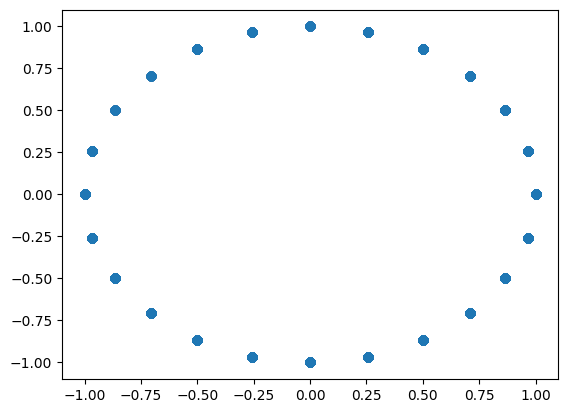

In [76]:
plt.scatter(youtube_df['hour_x_coord'], youtube_df['hour_y_coord'])

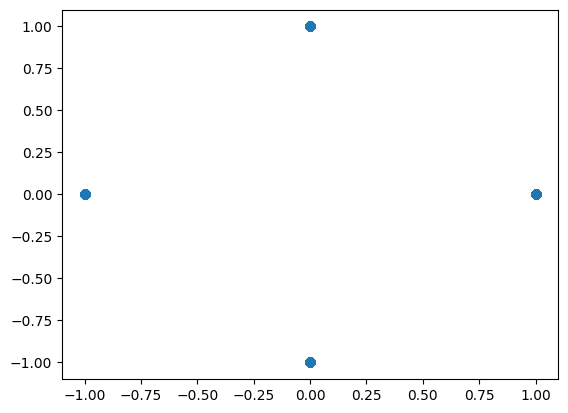

In [77]:
plt.scatter(youtube_df['time_of_day_x_coord'], youtube_df['time_of_day_y_coord'])

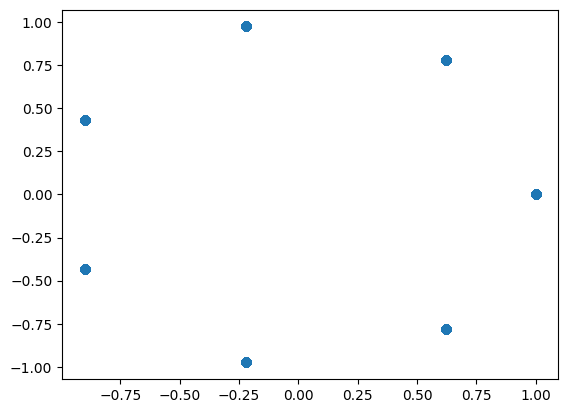

In [78]:
plt.scatter(youtube_df['day_of_week_x_coord'], youtube_df['day_of_week_y_coord'])

In [79]:
# Target encode the category label
encoder = TargetEncoder(target_type='continuous')

# TODO: This needs to be restructured so the encoding happens after splitting the data into test and training sets to avoid data leakage
encoded_category_labels = encoder.fit_transform(pd.DataFrame(youtube_df['category_label']), youtube_df['views'])
youtube_df['category_labels_encoded'] = encoded_category_labels
youtube_df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,hour,time_of_day,day_of_week,hour_x_coord,hour_y_coord,time_of_day_x_coord,time_of_day_y_coord,day_of_week_x_coord,day_of_week_y_coord,category_labels_encoded
0,y6KYFcta4SE,18.28.01,"1 dead, others injured after Ky. school shooting",Newsy,25,2018-01-23 15:30:01+00:00,"shooting|""kentucky""|""breaking news""|""u.s. news""|""marshall county high school""|""dead""|""fatality""|""injured""|""students""|""school""|""governor matt bevin""",559,9,0,...,15,1,1,-0.707107,-7.071068e-01,6.123234e-17,1.000000e+00,0.623490,0.781831,4.661310e+05
1,-JVITToppE0,17.17.11,Coach Taggart Monday Presser Ahead of Arizona,GoDucksdotcom,17,2017-11-13 20:41:45+00:00,"Oregon|""Ducks""|""college athletics""|""college football""|""college basketball""|""Tracktown USA""|""Track & Field""|""Hayward Field""|""Autzen Stadium""|""NIKE""",704,10,2,...,20,2,0,0.500000,-8.660254e-01,-1.000000e+00,1.224647e-16,1.000000,0.000000,1.435996e+06
2,dQMZLXaa1L8,18.29.01,Artwork Forge,Palo Alto Online,17,2018-01-10 23:53:56+00:00,[none],745,1,0,...,23,3,2,0.965926,-2.588190e-01,-1.836970e-16,-1.000000e+00,-0.222521,0.974928,1.435996e+06
3,zeQaJGkFyqQ,18.18.01,"Raw: 3 South Carolina Deputies, 1 Officer Shot",Associated Press,25,2018-01-16 12:16:44+00:00,"news|""associated press""|""ap""|""ap online""|""associated press style""|""breaking news""|""latest news""|""business""|""finance""|""politics""|""local news""|""commentary""|""reports""|""current affairs""|""top news""|""headlines""|""news today""|""charlotte""|""north carolina""|""united states""|""north america""|""south carolina""|""national""|""regional (ap video-us only""|""charlotte police shooting""|""raw""|""south""|""carolina""|""deputies""|""officer""|""shot""",748,9,0,...,12,1,1,-1.000000,1.224647e-16,6.123234e-17,1.000000e+00,0.623490,0.781831,4.661310e+05
4,qg0GdM60syI,17.14.11,Huffy Metaloid Bicycle Commercial 1997,90s Commercials,27,2017-03-31 21:46:53+00:00,"90s commercials|""Huffy""",773,2,0,...,21,3,4,0.707107,-7.071068e-01,-1.836970e-16,-1.000000e+00,-0.900969,-0.433884,5.971086e+05
